# Data Munging
## A Case Study Mapping Coalbed Regions to Control Areas
This notebook shows the various steps and techniques used to map coal basins to their respective balancing authority areas using a simple areal-weighting approach.
This is one step in the overall task of determining the appropriate default providers of electricity consumption during the raw material extraction stage of the electricity generation life cycle.

Author:
    Tyler W. Davis

Created:
    2024-01-23

Updated:
    2024-02-21

### Data: The Gathering
The task is to map U.S. coal basin regions to their respective balancing authority areas.

Where to start?

To the internet!

A general web search (and some experiential knowledge of what sites to look at) revealed a spatial dataset on the [Homeland Infrastructure Foundation-Level Data (HIFLD)](https://hifld-geoplatform.hub.arcgis.com/) data hub.
To get to this search, keywords, such as "spatial data" or "geospatial" were added to the web search---this is because the task requires us to perform a spatial analysis between the shared locations of the coal basins and balancing authority areas.

On HIFLD's public domain data page, search "control areas," and there is one match (e.g., [Control Areas](https://hifld-geoplatform.hub.arcgis.com/datasets/db7622e5ebdd40428fcafbd1615d621a_0/explore),
which represents the spatial boundaries of electricity control areas, also called balancing authority areas.

HIFLD uses Esri's ArcGIS data hub to provide the data.
There's a button on the site for "I want to use this" and find the __API__ resource.

> __API__: 
>
> APIs (or application programming interfaces) provide structured data from third-party sources, providing software with the means to communicate with one another and allowing the retrieval of data from external sources.


#### API
A common API is a special URL with query information attached and the server reads the query and returns the structured data requested to the user.
The webAPI URL used for this data set is given below, broken into its parts.
Note that `%3D` is the HTML language for the equal sign, `=`.

    https://services1.arcgis.com            # the host
    /Hp6G80Pky0om7QvQ/arcgis/rest/services  # the API service
    /Control_Areas_gdb/FeatureServer/0/     # the address
    query?where=1%3D1&outFields=*&outSR=4326&f=geojson # the query

The query can be the difficult part.
Luckily, HIFLD provides this query for us.

Breaking it down:

- `where=1&eD1` --- this says where 1 equals 1, which is always true, which means that all features are fetched.
- `outFields=*` --- this uses the wildcard, `*`, which stands for 'all matching fields'; otherwise, a comma separated list of field names could be given
- `outSR=4326` --- this is the spatial reference system; for GeoJSON files, it should always be [WGS84](https://epsg.io/4326)
- `f=geojson` --- the requested structured format, a geospatial Java Script Object Notation (a standard for web-based data)

The website should return JSON-formatted text, which we can save to a file.

Let's define the URL, define the file we want, and ask the API for data.

In [ ]:
# Get the required Python libraries to help us out.
import os                # for file and folder paths & existence
import urllib.request    # for requesting data from the web

In [ ]:
# Define the API URL, the file name, and a directory to keep us organized.
ba_api_url = (
    "https://services1.arcgis.com/"
    "Hp6G80Pky0om7QvQ/arcgis/rest/services/Control_Areas_gdb/"
    "FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson")
ba_file = "control_areas.geojson"
data_dir = "data"
ba_path = os.path.join(data_dir, ba_file)

In [ ]:
# Check to make sure data directory exists before attempting download!
# If it doesn't exist, create a new folder.
if not os.path.isdir(data_dir):
    print("Creating data folder")
    os.makedirs(data_dir)

In [ ]:
# Check to see if we already downloaded this file,
# if not, ask the API for the data and save to file
if not os.path.isfile(ba_path):
    urllib.request.urlretrieve(ba_api_url, ba_path)

It's that easy!

Let's take a look at what we got.

In [ ]:
# Get the required Python libraries to help us out.
import geopandas as gpd  # for handling geospatial datasets

In [ ]:
# Read GeoJSON
gdf = gpd.read_file(ba_path)

### Data Exploration
With new data, it's a good idea to inspect what you are working with.
Let's start with just a peek at the data.

In [ ]:
gdf.head()

So much going on here!

Let's look just at the info associated with the data to help give us an idea of what's going on.

In [ ]:
gdf.info()

Okay, we have 29 attributes for 71 data entries.
We can see the attribute names and data types for each.

Note that during inspection, you are probably also looking for potential transformations (e.g., data in the wrong type), irrelevant data (e.g., filtering based on feature selection for simplicity), and errors (e.g., for cleansing). 

Here's some first impression take-aways:

- I don't see any null values, so there may be no missing data.
    - Note that sometimes, missing data are given as a huge negative value for easy filtering.
- I see dates as integers (e.g., SOURCEDATE and VAL_DATE) not date objects and year as object (i.e., string) not integer: we have potential data transformations.
- I see metadata that I probably don't need (e.g., address info, telephone, NAICS info, monthly peaks, loads, capacities, and planned outputs): potential filtering and cleaning.
- No indications of sampling: I expected 69--71 balancing authority areas and that's what we got.
- No coal basin info, so I expect data integration.


Let's check for missing data.

In [ ]:
gdf.describe()

Yep.

We see the occurrence of that massively negative value (see min row above).

Who's the culprit?

In [ ]:
gdf[gdf['PEAK_MONTH'] == -999999]

It looks like there are six areas with no metadata for their operations; however, it appears that their location data are okay.
Perhaps this isn't a case for data filtering, since we don't need this info.

Let's investigate the potential transformation data starting with the two dates.

In [ ]:
gdf[['SOURCEDATE', 'VAL_DATE']].describe()

These appear to be really large numbers (i.e., 1e+12).
When you see dates expressed this way, there's a good chance it's a representation of time using an epoch (e.g., Unix Epoch).

> __Unix Epoch__:
>
> A measure of non-leap seconds that have elapsed since a given starting point in history (e.g., 00:00:00 UTC on 1 January 1970).
> Certain computing environments include additional granularity (e.g., milliseconds).
>
> The Unix Epoch (in seconds) for 13:33:10 EST February 21, 2024 is 1708540390 (note the timezone).

You can see the current Unix Epoch [here](https://www.epochconverter.com/).

For seconds, the expected integer is on the order of 1e+9.
Our data is on the order of 1e+12, which means that it is likely in milliseconds.

Let's see if we can make sense of this data using Python's datetime library.

In [ ]:
import datetime

In [ ]:
# Pull the first value
e_time = gdf.loc[0, 'SOURCEDATE']
e_time

In [ ]:
datetime.datetime.fromtimestamp(e_time/1000)

It looks like this data point is from 8:00 PM on June 20, 2021.

Let's see when it's valid til:

In [ ]:
v_time = gdf.loc[0, 'VAL_DATE']
v_time

In [ ]:
datetime.datetime.fromtimestamp(v_time/1000)

It looks like this data is valid for one year.

Now that we know how to convert this, should we?

> __QUESTION__: Why store dates as integers?
>
> It is more memory efficient to store integers (e.g., 32-bit signed integer) than a datetime object (i.e., 64-bit object), particularly for large datasets.
> This translates to a signifant storage savings.
> See also, the 'Year 2038 Problem,' when the 32-bit integer falls short of memory requirements for a January 1970 epoch.
> 
> Furthermore, there are regional differences in how dates and times are written (e.g., 2/21/24 3:33 PM is the same as 2024-02-21 15:33 is the same as 3:33 PM 21 Feb 2024) and can cause trouble with automated systems.
> A single integer is expressed the same for all the various written formats.


What about the year attribute?

In [ ]:
gdf['YEAR'].describe()

It looks like we have four unique values with 2020 as the most frequent (63 occurrences out of 71).

In [ ]:
gdf['YEAR'].unique()

Hmm.

Strange that we have 'NOT AVAILABLE' as an entry.
This could be the culprit as to why the data were stored as strings and not integers.

Let's see who the culprit is.

In [ ]:
gdf[gdf['YEAR'] == 'NOT AVAILABLE']

Some of these are familiar with the ones we saw above with missing meta data.

Again, we may not be too worried, since the year data is not really that concerning.

The next important step for inspection is the visualization of our data.

Let's take a look!

In [ ]:
# Fix notebook plotting scale
# Source: https://mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
# Create a reference map highlighing the different areas
gdf.plot(cmap="rainbow", column='NAME')

It looks like there are states outside the lower 48.
Let's check to make sure:

In [ ]:
gdf.sort_values(by='STATE', ascending=True)['STATE'].unique()

Yes, there's Alaska (AK) and Hawaii (HI).
At first glance, we might be convinced that 'NB' is Nebraska, but Nebraska is NE: this is New Brunswick, Canada!

While there are balancing authority areas associated with these states, let's assume the study region is the conterminous U.S.

Otherwise, it looks like our dataset covers the whole region of interest.

### Cleansing
The name, state, and country info seems relevant as we move forward.
There are gaps in the generation data, so we can drop that.
The source, source dates, valid dates, and website might be relevant when writing up our data summary later on, so keep that.
No relevant info in VAL_METHOD, so drop.
The gappy metadata goes.
The spatial data and identifiers stay.

In [ ]:
gdf.columns

In [ ]:
keep_cols = [
    'OBJECTID',
    'ID',
    'NAME',
    'STATE',
    'COUNTRY',
    'SOURCE',
    'SOURCEDATE',
    'VAL_DATE',
    'WEBSITE',
    'SHAPE__Area',
    'SHAPE__Length',
    'GlobalID',
    'geometry'
]
drop_cols = [x for x in gdf.columns if x not in keep_cols]
drop_cols

In [ ]:
gdf = gdf.drop(columns=drop_cols)

### More Than Meets The Eye
Let's transform the dates in the dataset so we can read them!

In [ ]:
# A quick one-liner to convert epoch time to datetime:
gdf['SRC_DATE'] = [datetime.datetime.fromtimestamp(x/1000) for x in gdf['SOURCEDATE'].values]

In [ ]:
gdf[['SOURCEDATE', 'SRC_DATE']]

### Integrate
We noted that not all the data we need are in one place; therefore, we need to integrate other data sources with this one.

A little research shows that EIA's [coalbed methane map data](https://www.eia.gov/maps/maps.htm) includes labels of the major coal beds.

Let's use that!

#### And we are back to gathering

In [ ]:
# Define the URL with the spatial data zip archive
coalbed_url = "https://www.eia.gov/maps/map_data/cbm_4shps.zip"

In [ ]:
# Let's save the zip to the same location as the BA GeoJSON
coalbed_zip = os.path.basename(coalbed_url)
coalbed_path = os.path.join(data_dir, coalbed_zip)
if not os.path.isfile(coalbed_path):
    print("Downloading zip file")
    urllib.request.urlretrieve(coalbed_url, coalbed_path)

In [ ]:
# Get the Python library needed to deal with zip files
from zipfile import ZipFile

In [ ]:
# Unzip the file and find the shapefile we want
# Note: A shapefile consists of several files that all must be located
#       together in order to be valid.
eia_zip = ZipFile(coalbed_path, 'r')
eia_shp = ""
eia_members = []
for tmp_shp in eia_zip.filelist:
    if "resources" in tmp_shp.filename:
        eia_members.append(tmp_shp)
        if tmp_shp.filename.endswith(".shp"):
            eia_shp = tmp_shp.filename
eia_zip.extractall(path=data_dir, members=eia_members)
eia_shp_path = os.path.join(data_dir, eia_shp)

In [ ]:
# Take a look at the shapefile files we extracted:
[x.filename for x in eia_members]

#### Investigation Round Two

In [ ]:
# Read the data
if os.path.isfile(eia_shp_path):
    eia_df = gpd.read_file(eia_shp_path)

In [ ]:
eia_df

It turns out there are too many basins being accounted for here and they do not all align with the electricity baseline coal basins.

Let's correct the basin names based on the expert advice that was given to us.

#### Filtering and Transformation

In [ ]:
# Create a function that transforms basin area names to electricity baseline
# coal basin codes and filters out any that are not defined.

def rename_coal_basins(df):
    """Create 'basin' attribute with electricity baseline basin codes.

    Parameters
    ----------
    df : pandas.DataFrame, geopandas.GeoDataFrame

    Returns
    -------
    pandas.DataFrame, geopandas.GeoDataFrame
        The same data frame recevied with a newly mapped 'basin' column.

    Notes
    -----
    """
    bas = []
    rm_basins = [
        'Big Horn Basin',
        'Denver Basin',
        'Goshen Hole Field',
        'Greater Green River',
        'Hannah-Carbon Basin',
        'HenryMtns-SWColorado',
        'Jackson Hole Field',
        'KaiparowitsBlackMesa',
        'North Central',
        'Raton',
        'Rock Creek Field',
        'San Juan',
        'Uinta-Piceance-Park',
        'Wind River',
        'Wyoming overthrust'
    ]

    for b in df.BASIN_AREA:
        if b == 'Central Appalachian':
            bas.append('CA')
        elif b == 'Arkoma' or b == 'Cherokee' or b == 'Forest City' or b == 'SW Coal Region':
            bas.append('CI')
        elif b == 'Gulf Coast':
            bas.append('GL')
        elif b == 'Illinois':
            bas.append('IB')
        elif b == 'Williston Basin':
            bas.append('L')
        elif b == 'Northern Appalachian':
            bas.append('NA')
        elif b == 'Powder River':
            bas.append('PRB')
        elif b in rm_basins:
            bas.append("RM")
        elif b == 'Black Warrior':
            bas.append('SA')
        elif b == 'Pacific':
            bas.append('WNW')
        else:
            bas.append('no_emf')

    df['basin'] = bas
    # Remove non-EIA basins
    df = df.query("basin != 'no_emf'")

    return df

In [ ]:
eia_df = rename_coal_basins(eia_df)

In [ ]:
eia_df.info()

Let's remove the unnecessary floating point attributes.

In [ ]:
eia_df = eia_df.drop(columns=['RSC_04_TCF', 'RSC_06_TCF'])

To integrate two spatial datasets, it is recommended that they are in the same spatial coordinate reference system and, since this is an area-weighted analysis, the coordinate system should be projected to a 2D reference system that preserves area.

One such reference system is the North America Lambert Conformal Conic (ESRI:102009).

Note that the linear unit of this coordinate system is the meter.

In [ ]:
# Perform a spatial reference system transformation
pcs = ('esri', 102009)
ba = gdf.to_crs(pcs)
cb = eia_df.to_crs(pcs)

#### Feature Selection
We now have two datasets, each with their own valuable information that we want in a single layer.

We need to preserve their areas in order to do area weighted analysis.

In [ ]:
# Preserve original coal basin and BA areas in square kilometers
ba['BAA_KM2'] = ba['geometry'].area / 10**6
cb['CB_KM2'] = cb['geometry'].area / 10**6

#### Data Integration
A simple spatial overlay merges the regions of interest together (see [Intersection](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/intersect.htm)).

In [ ]:
area_df = gpd.overlay(ba, cb, how='intersection')

In [ ]:
# Calculate the area of the overlaps in square kilometers:
area_df['AREA_KM2'] = area_df['geometry'].area / 10**6

### Visualize
For ease of visualization, we often employ a base map.
For the U.S., let's use a state map.

In [ ]:
# Gather, filter, and transform US states (for basemap)
us_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json"
us_df = gpd.read_file(us_url)
non_cont = ['Alaska', 'Hawaii', 'Puerto Rico']
us_df = us_df.query("NAME not in @non_cont").copy()
us = us_df.to_crs(pcs)

In [ ]:
ax = area_df.plot(cmap="rainbow", column='NAME')
us.plot(ax=ax, facecolor='none', edgecolor='black')
area_df.plot(ax=ax, facecolor="white", column='basin', edgecolor='gray')

## Analysis
We have wrangled our data and we are ready for further analysis!

# Appendix
Below is the source code used to create the case study above.

In [ ]:
# Required Modules
import logging
import os
import urllib.request
from zipfile import ZipFile

import pandas as pd
import geopandas as gpd


# Methods
def correct_ba_geo_names(ba_geo_df):
    """Create new named column, 'BA_NAME', with mapped balancing authority
    names from HILD geospatial dataset to 2020 EIA Form 860 names.

    Notes
    -----
    Not all 2021 balancing authority names match the 2020 EIA Form 860 names
    and not all EIA Form 860 balancing authorities are represented in the HILD
    geo dataset (e.g., Hawaiian and Canadian authorities).

    The corrections are not as simple as making the names title case (e.g.,
    LLC, JEA, and AVBA); also, some uncertainty remains with current matches,
    such as 'Salt River Project' and 'NorthWestern Corporation'.

    Mix names that are unmatched in the geo data frame, include the following.

    -  'B.C. Hydro & Power Authority'
    -  'Hydro-Quebec TransEnergie'
    -  'Manitoba Hydro'
    -  'Ontario IESO'

    An alternative would be to match all BA areas to their representative
    BA codes, which there exists code for doing just that in scenario modeler's
    BA class.

    Parameters
    ----------
    ba_geo_df : geopandas.GeoDataFrame
        The geospatial data frame created in :func:`get_ba_geo`.

    Returns
    -------
    geopandas.GeoDataFrame
        The same as the input data frame with a new mapped column, 'BA_NAME'.
    """
    m_dict = {
        'NEW BRUNSWICK SYSTEM OPERATOR': (
            'New Brunswick System Operator'),
        'POWERSOUTH ENERGY COOPERATIVE': (
            'PowerSouth Energy Cooperative'),
        'ALCOA POWER GENERATING, INC. - YADKIN DIVISION': (
            'Alcoa Power Generating, Inc. - Yadkin Division'),
        'ARIZONA PUBLIC SERVICE COMPANY': (
            'Arizona Public Service Company'),
        'ASSOCIATED ELECTRIC COOPERATIVE, INC.': (
            'Associated Electric Cooperative, Inc.'),
        'BONNEVILLE POWER ADMINISTRATION': (
            'Bonneville Power Administration'),
        'CALIFORNIA INDEPENDENT SYSTEM OPERATOR': (
            'California Independent System Operator'),
        'DUKE ENERGY PROGRESS EAST': (
            'Duke Energy Progress East'),
        'PUBLIC UTILITY DISTRICT NO. 1 OF CHELAN COUNTY': (
            'Public Utility District No. 1 of Chelan County'),
        'CHUGACH ELECTRIC ASSN INC': (
            'Chugach Electric Assn Inc'),
        'PUD NO. 1 OF DOUGLAS COUNTY': (
            'PUD No. 1 of Douglas County'),
        'DUKE ENERGY CAROLINAS': (
            'Duke Energy Carolinas'),
        'EL PASO ELECTRIC COMPANY': (
            'El Paso Electric Company'),
        'ELECTRIC RELIABILITY COUNCIL OF TEXAS, INC.': (
            'Electric Reliability Council of Texas, Inc.'),
        'ELECTRIC ENERGY, INC.': (
            'Electric Energy, Inc.'),
        'FLORIDA POWER & LIGHT COMPANY': (
            'Florida Power & Light Co.'),
        'DUKE ENERGY FLORIDA INC': (
            'Duke Energy Florida, Inc.'),
        'GAINESVILLE REGIONAL UTILITIES': (
            'Gainesville Regional Utilities'),
        'CITY OF HOMESTEAD': (
            'Homestead, City of'),
        'IDAHO POWER COMPANY': (
            'Idaho Power Company'),
        'IMPERIAL IRRIGATION DISTRICT': (
            'Imperial Irrigation District'),
        'JEA': (
            'JEA'),
        'LOS ANGELES DEPARTMENT OF WATER AND POWER': (
            'Los Angeles Department of Water and Power'),
        'LOUISVILLE GAS AND ELECTRIC COMPANY AND KENTUCKY UTILITIES': (
            'LG&E and KU Services Company as agent for Louisville Gas '
            'and Electric Company and Kentucky Utilities Company'),
        'NORTHWESTERN ENERGY (NWMT)': (
            'NorthWestern Corporation'),
        'NEVADA POWER COMPANY': (
            'Nevada Power Company'),
        'ISO NEW ENGLAND INC.': (
            'ISO-NE'),
        'NEW SMYRNA BEACH, UTILITIES COMMISSION OF': (
            'New Smyrna Beach, Utilities Commission of'),
        'NEW YORK INDEPENDENT SYSTEM OPERATOR': (
            'New York Independent System Operator'),
        'OHIO VALLEY ELECTRIC CORPORATION': (
            'Ohio Valley Electric Corporation'),
        'PACIFICORP - WEST': (
            'PacifiCorp West'),
        'PACIFICORP - EAST': (
            'PacifiCorp East'),
        'GILA RIVER POWER, LLC': (
            'Gila River Power, LLC'),
        'FLORIDA MUNICIPAL POWER POOL': (
            'Florida Municipal Power Pool'),
        'PUBLIC UTILITY DISTRICT NO. 2 OF GRANT COUNTY, WASHINGTON': (
            'Public Utility District No. 2 of Grant County, Washington'),
        'PJM INTERCONNECTION, LLC': (
            'PJM Interconnection, LLC'),
        'PORTLAND GENERAL ELECTRIC COMPANY': (
            'Portland General Electric Company'),
        'AVANGRID RENEWABLES LLC': (
            'Avangrid Renewables LLC'),
        'PUBLIC SERVICE COMPANY OF COLORADO': (
            'Public Service Company of Colorado'),
        'PUBLIC SERVICE COMPANY OF NEW MEXICO': (
            'Public Service Company of New Mexico'),
        'PUGET SOUND ENERGY': (
            'Puget Sound Energy, Inc.'),
        'BALANCING AUTHORITY OF NORTHERN CALIFORNIA': (
            'Balancing Authority of Northern California'),
        'SALT RIVER PROJECT': (
            'Salt River Project Agricultural Improvement and Power District'),
        'SEATTLE CITY LIGHT': (
            'Seattle City Light'),
        'SOUTH CAROLINA ELECTRIC & GAS COMPANY': (
            'South Carolina Electric & Gas Company'),
        'SOUTH CAROLINA PUBLIC SERVICE AUTHORITY': (
            'South Carolina Public Service Authority'),
        'SOUTHWESTERN POWER ADMINISTRATION': (
            'Southwestern Power Administration'),
        'SOUTHERN COMPANY SERVICES, INC. - TRANS': (
            'Southern Company Services, Inc. - Trans'),
        'CITY OF TACOMA, DEPARTMENT OF PUBLIC UTILITIES, LIGHT DIVISION': (
            'City of Tacoma, Department of Public Utilities, Light Division'),
        'CITY OF TALLAHASSEE': (
            'Tallahassee, City of'),
        'TAMPA ELECTRIC COMPANY': (
            'Tampa Electric Company'),
        'TENNESSEE VALLEY AUTHORITY': (
            'Tennessee Valley Authority'),
        'TURLOCK IRRIGATION DISTRICT': (
            'Turlock Irrigation District'),
        'HAWAIIAN ELECTRIC CO INC': (
            'Hawaiian Electric Co Inc'),
        'WESTERN AREA POWER ADMINISTRATION UGP WEST': (
            'Western Area Power Administration - Upper Great Plains West'),
        'AVISTA CORPORATION': (
            'Avista Corporation'),
        'SEMINOLE ELECTRIC COOPERATIVE': (
            'Seminole Electric Cooperative'),
        'TUCSON ELECTRIC POWER COMPANY': (
            'Tucson Electric Power'),
        'WESTERN AREA POWER ADMINISTRATION - DESERT SOUTHWEST REGION': (
            'Western Area Power Administration - Desert Southwest Region'),
        'WESTERN AREA POWER ADMINISTRATION - ROCKY MOUNTAIN REGION': (
            'Western Area Power Administration - Rocky Mountain Region'),
        'SOUTHEASTERN POWER ADMINISTRATION': (
            'Southeastern Power Administration'),
        'NEW HARQUAHALA GENERATING COMPANY, LLC - HGBA': (
            'New Harquahala Generating Company, LLC - HGBA'),
        'GRIFFITH ENERGY, LLC': (
            'Griffith Energy, LLC'),
        'NATURENER POWER WATCH, LLC (GWA)': (
            'NaturEner Power Watch, LLC (GWA)'),
        'GRIDFORCE SOUTH': (
            'Gridforce South'),
        'MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM OPERATOR, INC..': (
            'Midcontinent Independent System Operator, Inc.'),
        'ARLINGTON VALLEY, LLC - AVBA': (
            'Arlington Valley, LLC - AVBA'),
        'DUKE ENERGY PROGRESS WEST': (
            'Duke Energy Progress West'),
        'GRIDFORCE ENERGY MANAGEMENT, LLC': (
            'Gridforce Energy Management, LLC'),
        'NATURENER WIND WATCH, LLC': (
            'NaturEner Wind Watch, LLC'),
        'SOUTHWEST POWER POOL': (
            'Southwest Power Pool'),
    }
    ba_geo_df['BA_NAME'] = ba_geo_df['NAME'].map(m_dict)

    return ba_geo_df


def download_file(url, filename):
    """
    Name:     download_file
    Features: Downloads a file located at a given URL to a location defined by
              a file name.
    Inputs:   - str, URL to a file (url)
              - str, file name to a given directory where data should be
                downloaded to
    Outputs:  None
    Ref:      This function utilizes the legacy function of urlib.request,
              which may one day go away. See also requests package for
              alternatives.
    """
    urllib.request.urlretrieve(url, filename)


def get_ba_codes():
    # This was added to populate a ba_codes variable that could be used
    # by other modules without having to re-read the excel files. The purpose
    # is to try and provide a common source for balancing authority names, as well
    # as FERC an EIA region names.
    data_url = (
        "https://github.com/USEPA/ElectricityLCI/raw/master"
        "/electricitylci/data/BA_Codes_930.xlsx"
    )
    ba_codes = pd.concat([
        pd.read_excel(
            f"{data_url}", header=4, sheet_name="US"
        ),
        pd.read_excel(
            f"{data_url}", header=4, sheet_name="Canada"
        ),
    ])
    ba_codes.rename(
        columns={
            "etag ID": "BA_Acronym",
            "Entity Name": "BA_Name",
            "NCR_ID#": "NRC_ID",
            "Region": "Region",
        },
        inplace=True,
    )
    ba_codes.set_index("BA_Acronym", inplace=True)

    return ba_codes


def get_ba_map():
    """Return a dictionary of balancing authority names and their abbreviations

    Returns
    -------
    dict
        A dictionary with keys of balancing authority names (as per EIA 923)
        and values of abbreviations.
    """
    ba_codes = get_ba_codes()
    ba_map = {}
    for idx, row in ba_codes.iterrows():
        ba_map[row['BA_Name']] = idx

    return ba_map


def get_ba_geo(data_dir=".", correct_names=False):
    """Create a geospatial data frame for U.S. control areas (i.e., balancing
    authorities).

    Run this method once to download a local copy of the GeoJSON.
    Subsequent runs of this method attempt to read the local file rather
    than re-download the file. The file name is "control_areas.geojson" and
    is saved in the DATA_DIR directory (e.g., ./data).

    Notes
    -----
    The API referenced in this method links to 2021 control areas, which were
    updated in 2022.

    When correcting BA names, there are a few that do not match the EIA 923
    names, which include Chugach Electric Assn Inc, Avangrid Renewables LLC,
    and Hawaiian Electric Co Inc.

    Source, "Control Areas" from Homeland Infrastructure Foundation Level
    Database (HIFLD). Online [1]_.

    [1] https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::control-areas/about

    Parameters
    ----------
    correct_names : bool, optional
        Whether to create a new named column, 'BA_NAME', with balancing
        authority names mapped to the EIA Form 860 balancing authority area
        names, defaults to false.

    Returns
    -------
    geopandas.geodataframe.GeoDataFrame
        A geospatial data frame of polygon areas representing the U.S.
        electricity control areas (i.e., balancing authorities).

        Columns include:

        - 'OBJECTID',
        - 'ID',
        - 'NAME',
        - 'ADDRESS',
        - 'CITY',
        - 'STATE',
        - 'ZIP',
        - 'TELEPHONE',
        - 'COUNTRY',
        - 'NAICS_CODE',
        - 'NAICS_DESC',
        - 'SOURCE',
        - 'SOURCEDATE',
        - 'VAL_METHOD',
        - 'VAL_DATE',
        - 'WEBSITE',
        - 'YEAR',
        - 'PEAK_MONTH',
        - 'AVAIL_CAP',
        - 'PLAN_OUT',
        - 'UNPLAN_OUT',
        - 'OTHER_OUT',
        - 'TOTAL_CAP',
        - 'PEAK_LOAD',
        - 'MIN_LOAD',
        - 'SHAPE__Area',
        - 'SHAPE__Length',
        - 'GlobalID',
        - 'geometry'
    """
    # NOTE: consider including comma-separated list of outFields, as not all
    # are needed and/or used.
    ba_api_url = (
        "https://services1.arcgis.com/"
        "Hp6G80Pky0om7QvQ/arcgis/rest/services/Control_Areas_gdb/"
        "FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson")
    ba_file = "control_areas.geojson"
    ba_path = os.path.join(data_dir, ba_file)

    # Check to make sure data directory exists before attempting download
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)

    # Use existing file if available:
    if not os.path.isfile(ba_path):
        download_file(ba_api_url, ba_path)

    # Read GeoJSON and correct BA area names (if requested)
    gdf = gpd.read_file(ba_path)
    if correct_names:
        gdf = correct_ba_geo_names(gdf)
        gdf = map_ba_codes(gdf)

    return gdf


def get_coal_geo(output_dir="."):
    # Define the URL
    coalbed_url = "https://www.eia.gov/maps/map_data/cbm_4shps.zip"
    coalbed_zip = os.path.basename(coalbed_url)
    coalbed_path = os.path.join(output_dir, coalbed_zip)
    download_file(coalbed_url, coalbed_path)

    # Unzip the file and find the shapefile we want
    eia_zip = ZipFile(coalbed_path, 'r')
    eia_shp = ""
    eia_members = []
    for tmp_shp in eia_zip.filelist:
        if "resources" in tmp_shp.filename:
            eia_members.append(tmp_shp)
            if tmp_shp.filename.endswith(".shp"):
                eia_shp = tmp_shp.filename
    eia_zip.extractall(path=output_dir, members=eia_members)
    eia_shp_path = os.path.join(output_dir, eia_shp)
    if os.path.isfile(eia_shp_path):
        eia_df = gpd.read_file(eia_shp_path)
        eia_df = rename_coal_basins(eia_df)
    else:
        eia_df = None
    return eia_df


def map_ba_codes(df):
    """Map balancing authority abbreviation codes based on EIA Form 930 naming.

    Parameters
    ----------
    df : pandas.DataFrame
        A data frame with column, 'Subregion' or 'BA_NAME' used to match
        against balancing authority abbreviation map.

    Returns
    -------
    pandas.DataFrame
        The same as the sent data frame with a new column, "BA_CODE".
    """
    m_col = 'Subregion'
    if 'Subregion' not in df.columns and 'BA_NAME' in df.columns:
        m_col = 'BA_NAME'
    elif 'Subregion' not in df.columns and 'BA_NAME' not in df.columns:
        logging.warning("No matching column for BA codes!")

    ba_map = get_ba_map()
    df['BA_CODE'] = df[m_col].map(ba_map)
    logging.info("%d mis-matched BA codes" % df['BA_CODE'].isna().sum())

    return df


def rename_coal_basins(df):
    bas = []
    rm_basins = [
        'Big Horn Basin',
        'Denver Basin',
        'Goshen Hole Field',
        'Greater Green River',
        'Hannah-Carbon Basin',
        'HenryMtns-SWColorado',
        'Jackson Hole Field',
        'KaiparowitsBlackMesa',
        'North Central',
        'Raton',
        'Rock Creek Field',
        'San Juan',
        'Uinta-Piceance-Park',
        'Wind River',
        'Wyoming overthrust'
    ]

    for b in df.BASIN_AREA:
        if b == 'Central Appalachian':
            bas.append('CA')
        elif b == 'Arkoma' or b == 'Cherokee' or b == 'Forest City' or b == 'SW Coal Region':
            bas.append('CI')
        elif b == 'Gulf Coast':
            bas.append('GL')
        elif b == 'Illinois':
            bas.append('IB')
        elif b == 'Williston Basin':
            bas.append('L')
        elif b == 'Northern Appalachian':
            bas.append('NA')
        elif b == 'Powder River':
            bas.append('PRB')
        elif b in rm_basins:
            bas.append("RM")
        elif b == 'Black Warrior':
            bas.append('SA')
        elif b == 'Pacific':
            bas.append('WNW')
        else:
            bas.append('no_emf')

    df['basin'] = bas
    # Remove non-EIA basins
    df = df.query("basin != 'no_emf'")

    return df

In [40]:
# attempt to fix plot scale
# source: https://mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [48]:
# US states (for basemap)
us_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json"
us_df = gpd.read_file(us_url)
non_cont = ['Alaska', 'Hawaii', 'Puerto Rico']
us_df = us_df.query("NAME not in @non_cont").copy()

In [6]:
# Coal basins:
cb = get_coal_geo()

In [13]:
# BA areas
ba = get_ba_geo(correct_names=True)

In [15]:
# project to 2D
pcs = ('esri', 102009)
ba = ba.to_crs(pcs)
cb = cb.to_crs(pcs)
us = us_df.to_crs(pcs)

<AxesSubplot: >

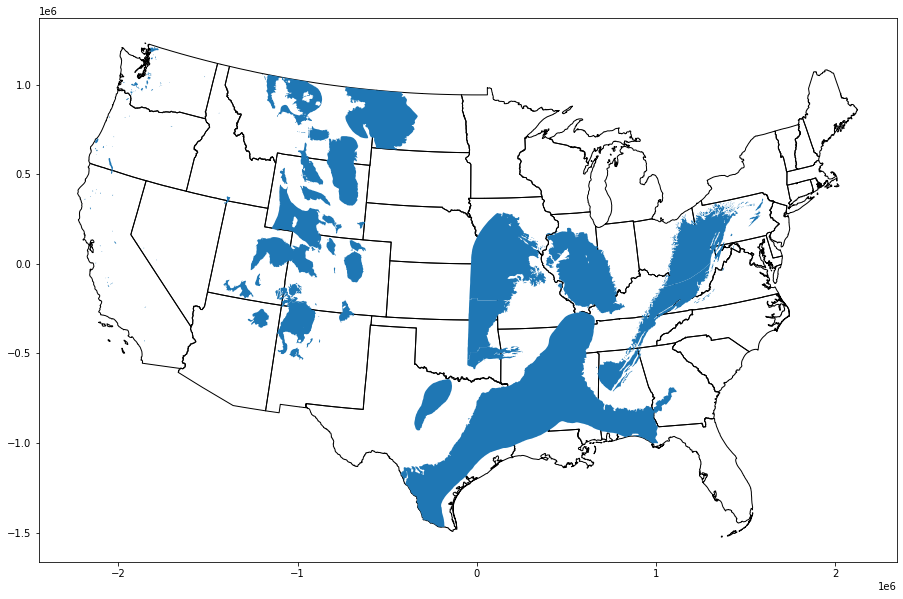

In [65]:
ax = us.plot(facecolor='none', edgecolor='black')
cb.plot(ax=ax)

<AxesSubplot: >

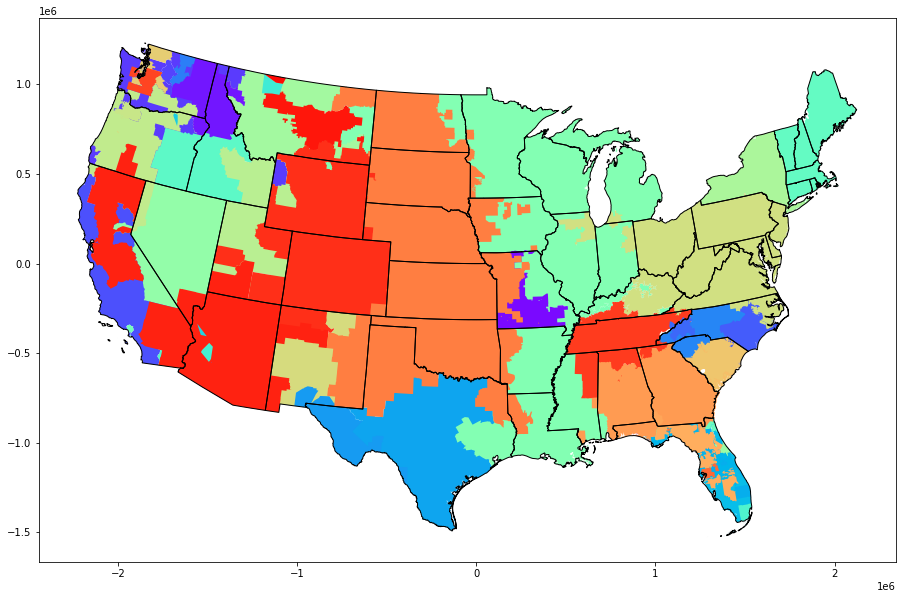

In [62]:
ax = ba.plot(cmap="rainbow", column='BA_CODE')
us.plot(ax=ax, facecolor='none', edgecolor='black')

<AxesSubplot: >

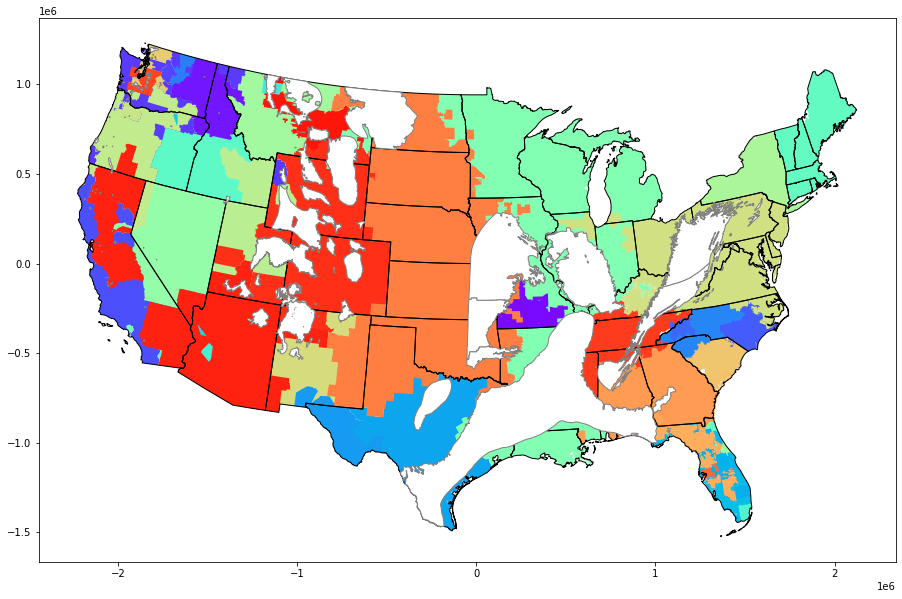

In [64]:
ax = ba.plot(cmap="rainbow", column='BA_CODE')
us.plot(ax=ax, facecolor='none', edgecolor='black')
cb.plot(ax=ax, facecolor="white", edgecolor='gray')

In [16]:
# Preserve original coal basin and BA areas
ba['BAA_KM2'] = ba['geometry'].area / 10**6
cb['CB_KM2'] = cb['geometry'].area / 10**6
area_df = gpd.overlay(ba, cb, how='intersection')
# Calculate the area of the overlaps in square kilometers:
area_df['AREA_KM2'] = area_df['geometry'].area / 10**6

<AxesSubplot: >

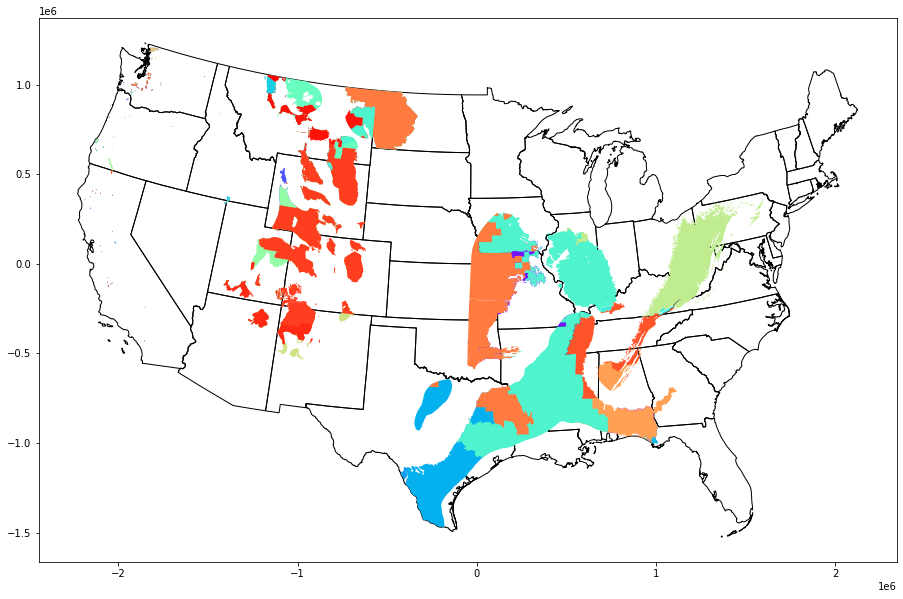

In [63]:
ax = us.plot(facecolor="none", edgecolor="black")
area_df.plot(ax=ax, cmap="rainbow", column="BA_CODE")

In [20]:
# Calculate fractional coverage
area_df['BA_FRAC'] = area_df['AREA_KM2'] / area_df['BAA_KM2']
area_df['CB_FRAC'] = area_df['AREA_KM2'] / area_df['CB_KM2']

In [22]:
# For each BA + coal basin, find the areas and their fractional coverage
tmp_df = area_df.groupby(
    by=['basin', 'BA_CODE',])[['AREA_KM2', 'CB_FRAC', 'BA_FRAC']].agg('sum')
tmp_df.index.names = ["Basin", "BA_CODE"]
tmp_df.reset_index(drop=False, inplace=True)

In [23]:
tmp_df

,Basin,BA_CODE,AREA_KM2,CB_FRAC,BA_FRAC
0,CA,LGEE,1753.373699,3.549167e-02,1.384754e-01
1,CA,PJM,36443.678025,7.376905e-01,6.838540e-02
2,CA,SOCO,0.000435,8.795696e-09,1.465657e-09
3,CA,TVA,11455.531336,2.318821e-01,6.410755e-02
4,CI,AECI,83458.759517,1.334958e+00,4.322777e-01
...,...,...,...,...,...
66,WNW,PACW,1357.288412,2.946872e-01,6.130180e-03
67,WNW,PGE,22.633246,4.914009e-03,2.405629e-03
68,WNW,PSEI,1627.701717,3.533979e-01,6.832528e-02
69,WNW,TPWR,1104.930264,2.398966e-01,6.526443e-02


In [24]:
# Convert absolute basin fractions to relative fractions (normalize)
#   after this, summing CB_FRAC for each state should give 1.0
for my_cb in tmp_df['Basin'].unique():
    my_rows = tmp_df['Basin'] == my_cb
    max_val = tmp_df.loc[my_rows, 'CB_FRAC'].sum()
    tmp_df.loc[my_rows, 'CB_FRAC'] /= max_val

In [29]:
# The final mix
cb_names = []
ba_names = []
mix_vals = []
for my_cb in tmp_df['Basin'].unique():
    my_rows = tmp_df['Basin'] == my_cb
    max_val = tmp_df.loc[my_rows, 'CB_FRAC'].sum()
    for my_ba in tmp_df.loc[my_rows, 'BA_CODE'].unique():
        my_r = (my_rows) & (tmp_df['BA_CODE'] == my_ba)
        my_v = tmp_df.loc[my_r, 'CB_FRAC'].sum()
        cb_names.append(my_cb)
        ba_names.append(my_ba)
        mix_vals.append(my_v)
        print(my_cb, my_ba, my_v)
    print(my_cb, "(total)", max_val)

CA LGEE 0.0353128392448584
CA PJM 0.7339734503258175
CA SOCO 8.751376411040773e-09
CA TVA 0.23071370167794764
CA (total) 1.0
CI AECI 0.2406549011912956
CI ERCO 0.18027150131498038
CI MISO 0.10453160996417436
CI SPA 4.591749371028101e-06
CI SWPP 0.4745373957801788
CI (total) 1.0000000000000002
GL AEC 0.06039873302364033
GL AECI 0.01644280831504888
GL EEI 0.0009652336729270356
GL EPE 0.02573127737252784
GL ERCO 0.22138128353686948
GL FPC 0.00437946375310308
GL JEA 0.00536764829245213
GL LGEE 0.0010618787385586219
GL MISO 0.40158244245195807
GL SEC 3.647939065977199e-05
GL SEPA 0.0001618267053972993
GL SOCO 0.12279632416629717
GL SPA 0.0022245566724960796
GL SWPP 0.07061532435138768
GL TVA 0.06685471955667659
GL (total) 1.0000000000000002
IB AECI 2.164020362726777e-05
IB LGEE 0.017946706225615547
IB MISO 0.903052538397728
IB PJM 0.0554970202044292
IB TVA 0.023482094968599865
IB (total) 0.9999999999999999
L MISO 0.40829956739288004
L NWMT 0.06053528189197365
L SWPP 0.3787672399292894
L WAC

In [31]:
df = pd.DataFrame({'Basin': cb_names, 'BA_Code': ba_names, 'Mix': mix_vals})

,Basin,BA_Code,Mix
0,CA,LGEE,3.531284e-02
1,CA,PJM,7.339735e-01
2,CA,SOCO,8.751376e-09
3,CA,TVA,2.307137e-01
4,CI,AECI,2.406549e-01
...,...,...,...
66,WNW,PACW,1.552862e-01
67,WNW,PGE,2.589450e-03
68,WNW,PSEI,1.862240e-01
69,WNW,TPWR,1.264141e-01


In [33]:
print(df.to_markdown())

|    | Basin   | BA_Code   |         Mix |
|---:|:--------|:----------|------------:|
|  0 | CA      | LGEE      | 0.0353128   |
|  1 | CA      | PJM       | 0.733973    |
|  2 | CA      | SOCO      | 8.75138e-09 |
|  3 | CA      | TVA       | 0.230714    |
|  4 | CI      | AECI      | 0.240655    |
|  5 | CI      | ERCO      | 0.180272    |
|  6 | CI      | MISO      | 0.104532    |
|  7 | CI      | SPA       | 4.59175e-06 |
|  8 | CI      | SWPP      | 0.474537    |
|  9 | GL      | AEC       | 0.0603987   |
| 10 | GL      | AECI      | 0.0164428   |
| 11 | GL      | EEI       | 0.000965234 |
| 12 | GL      | EPE       | 0.0257313   |
| 13 | GL      | ERCO      | 0.221381    |
| 14 | GL      | FPC       | 0.00437946  |
| 15 | GL      | JEA       | 0.00536765  |
| 16 | GL      | LGEE      | 0.00106188  |
| 17 | GL      | MISO      | 0.401582    |
| 18 | GL      | SEC       | 3.64794e-05 |
| 19 | GL      | SEPA      | 0.000161827 |
| 20 | GL      | SOCO      | 0.122796    |
| 21 | GL  

In [38]:
area_df.drop_duplicates(subset=['basin'])[['basin', 'BASIN_AREA', 'BA_CODE']]

,basin,BASIN_AREA,BA_CODE
0,GL,Gulf Coast,AEC
15,SA,Black Warrior,AEC
18,IB,Illinois,AECI
23,CI,Arkoma,AECI
32,PRB,Powder River,BPAT
38,RM,North Central,BPAT
44,WNW,Pacific,BPAT
71,CA,Central Appalachian,LGEE
75,NA,Northern Appalachian,LGEE
79,L,Williston Basin,NWMT
